## Front Matter
I want the Notebook to be as informative as possible, but model creating and training process follows some standard procedure that I do not want to repeat. Therefore, if you can, spend time reading the `PROLOGUE/Routine.ipynb` Notebook first.

# Convolutional Neural Network - Tiny (TinyCNN)
CNN is a great class of model architecture inspired by the human biological eyes and particularly suited for computer vision task. The essential difference of CNN model is the introduction of two new operation: "convolution" and "max-pooling", respectively `nn.Conv2d()` and `nn.MaxPool2d()` in PyTorch. Let's explore them first.

To begin, let's finish installing and importing all the necessary modules as we need some example data.

In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install --upgrade mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 36.4 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [3]:
from torch import nn
import torch
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

from torchmetrics import ConfusionMatrix, Accuracy
from mlxtend.plotting import plot_confusion_matrix


# Import tqdm for progress bar
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [4]:
train_data = datasets.KMNIST(root='data',
                                   transform=ToTensor(),
                                   download=True)
test_data = datasets.KMNIST(root='data',
                                  transform=ToTensor(),
                                  download=True,
                                  train=False)

In [5]:
image, label = train_data[1]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

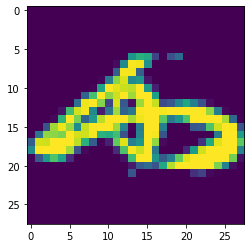

In [6]:
plt.imshow(image.squeeze());

## Convolution and Max-Pooling:
Okay, in the introduction, I say convolution is just `nn.Conv2d()`. It is partially incorrect. For the task of image classification in this notebook, yes, `nn.Con2d()` is what we need, because our image data have just 2 dimensions: height and width. For text, which is 1-dimensional, you will need `nn.Conv1d()`, and for 3D objects, of course there is `nn.Conv3d()`. The same is true for `nn.MaxPool2d()`.

### Convolution
First, let's talk about convolution. The intuition is *a convolution layer will apply a filter on the data and try to extract a fundamental pattern out of the data*. Mathematically, it is represented by an example operation:

- We take an image such as above, which has $n*m$ pixel
- We have a *filter*, or a *kernel*, which is essentially a matrix of size $p*q$, and is smaller than the image. It is usually seen that that kernel is square a.k.a of size $p*p$. The value at each position of the kernel is a *weight* in the layer (Yup, we're gonna multiply them with something next).
- We pick a region in the image of size $p*p$, starting from the top-left-most pixel, and perform element-wise multiplication with the kernel, receiving an intermediate matrix of size $p*p$. Next, we will sum together all the elements of the intermediate matrix plus the *bias* term. We get a single value, which could be thought of as a single new pixel in this case.
- We consecutively pick the next region, moving right one pixel at a time, going down one pixel at a time, until we hit the right-bottom-most pixel. The new pixel values are place side-by-side in the exact sequence of calculation.
- If you still have no idea what I am talking about, take a look at this website: [CNN Explainer](https://poloclub.github.io/cnn-explainer/).

The operation described above is the most simple case, one can specify many things differently. A quick look at the attributes of `nn.Conv2d()` yields:

- `in_channels` (int) – Number of channels in the input image. Usually referred to number of color channels.
- `out_channels` (int) – Number of channels produced by the convolution.
- `kernel_size` (int or tuple) – Size of the convolving kernel. Passing just a number (such as 3) and we get a square kernel, passing a tuple of integers and we will get a non-square kernel.
- `stride` (int or tuple, optional) – Stride of the convolution. Default: 1. Essentially how many pixel we will move right to pick a new region. Pick a stride $n$ bigger than 1 and we will skip $n-1$ pixel at a time.
- `padding` (int, tuple or str, optional) – Padding added to all four sides of the input. Default: 0. Padding is a little special. If you do the math, you will realize that convolution will reduce each dimension of the image by $p-1$ pixels for a kernel of size $p*p$. In the common case of kernel size 3, each dimension will reduce by 2, but by setting `padding=1`, the output image will have the same dimensions as the the input image.
- `padding_mode` (str, optional) – `'zeros'`, `'reflect'`, `'replicate'` or `'circular'`. Default: `'zeros'`

Now let's jump into the code. The `conv` instance we created takes in image with just 1 color channel, and output image with 1 color channel. `kernel_size` is $3*3$, or picking out 9 pixels at a time. `stride` is 1, which means we does not skip any pixel. There is no padding to the original image, which makes the new image have dimensions $26*26$.

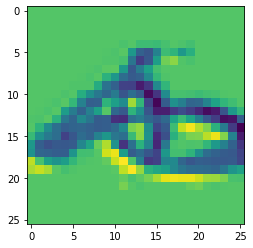

In [7]:
torch.manual_seed(17)

conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0)
conv_image = conv(image)
plt.imshow(conv_image.squeeze().detach().numpy());

Honestly, this is not much to see, as the convolution weights are just randomly initialized and means next to nothing. However, after training, convolution can become very good at picking out pattern. Just checking out [this demonstration](https://youtu.be/htiNBPxcXgo?t=3085) by Jeremy, where he showed a convolution that pick out the horizontal edges. Do what the next part as well, where he trained the convolution neural network in Excel!

Next, let's jump into Max-Pooling

### Max-Pooling
As the name suggests, we now still have a kernel of some size, let's say $p*p$. We will go through a square region of $p^2$ pixels at a time, and output the maximum value of the region. Then we will move to the next region, usually with a stride of $p-1$ i.e. the next region has no common pixel with any previous region. Without padding, this means that the output image will have its dimensions divided by p.

The attributes of `nn.MaxPool2d()` is essentially similar to `nn.Conv2d()`. For the code, `max_pool` is a max-pooling layer with a kernel size of 2, and that's it.

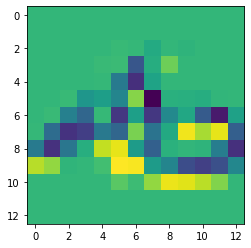

In [8]:
max_pool = nn.MaxPool2d(kernel_size=2)
max_pool_image = max_pool(conv_image)
plt.imshow(max_pool_image.squeeze().detach().numpy());

The model I build will be aptly named TinyVGG, with the architecture adapted from [CNN Explainer](https://poloclub.github.io/cnn-explainer/) mentioned above.

In [9]:
BATCH_SIZE = 2048

TrainLoader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
TestLoader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

In [10]:
print(f"Dataloaders: {TrainLoader, TestLoader}") 
print(f"Length of train dataloader: {len(TrainLoader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(TestLoader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7ff4903aa550>, <torch.utils.data.dataloader.DataLoader object at 0x7ff4903aafa0>)
Length of train dataloader: 30 batches of 2048
Length of test dataloader: 5 batches of 2048


In [11]:
class_names = train_data.classes
class_names

['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
class TinyConvNet(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*7*7, output_shape)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

In [14]:
torch.manual_seed(17)
model = TinyConvNet(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model

TinyConvNet(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [16]:
accuracy = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

In [17]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               metric: Accuracy,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X,y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss & accuracy
        loss = criterion(y_pred, y)
        train_loss += loss
        train_acc += metric(y_pred.argmax(dim=1), y)

        # 3. Empty out gradient
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimize 1 step
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")

In [18]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module,
               metric: Accuracy,
               device: torch.device = device):
    test_loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for (X,y) in data_loader:
            X, y = X.to(device), y.to(device)
        # 1. Forward pass
            y_pred = model(X)

        # 2. Calculate loss & accuracy
            test_loss += criterion(y_pred, y)
            acc += metric(y_pred.argmax(dim=1), y)

        test_loss /= len(data_loader)
        acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {acc:.2f}")

In [19]:
epochs = 20
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=TrainLoader, 
        model=model, 
        criterion=criterion,
        optimizer=optimizer,
        metric=accuracy,
        device=device
    )
    test_step(data_loader=TestLoader,
        model=model,
        criterion=criterion,
        metric=accuracy,
        device=device
    )


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.30309 | Train accuracy: 0.10
Test loss: 2.30214 | Test accuracy: 0.12
Epoch: 1
---------
Train loss: 2.30146 | Train accuracy: 0.11
Test loss: 2.30087 | Test accuracy: 0.14
Epoch: 2
---------
Train loss: 2.29937 | Train accuracy: 0.12
Test loss: 2.29867 | Test accuracy: 0.14
Epoch: 3
---------
Train loss: 2.29444 | Train accuracy: 0.19
Test loss: 2.29213 | Test accuracy: 0.20
Epoch: 4
---------
Train loss: 2.26622 | Train accuracy: 0.29
Test loss: 2.22187 | Test accuracy: 0.30
Epoch: 5
---------
Train loss: 1.77649 | Train accuracy: 0.49
Test loss: 1.63724 | Test accuracy: 0.50
Epoch: 6
---------
Train loss: 1.19701 | Train accuracy: 0.63
Test loss: 1.84510 | Test accuracy: 0.49
Epoch: 7
---------
Train loss: 1.01789 | Train accuracy: 0.68
Test loss: 1.51725 | Test accuracy: 0.50
Epoch: 8
---------
Train loss: 0.89062 | Train accuracy: 0.73
Test loss: 1.27252 | Test accuracy: 0.60
Epoch: 9
---------
Train loss: 0.80031 | Train accuracy: 0.75
Test loss: 

Our model looks good! Let's make prediction on the test set.

In [20]:
# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(TestLoader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/5 [00:00<?, ?it/s]

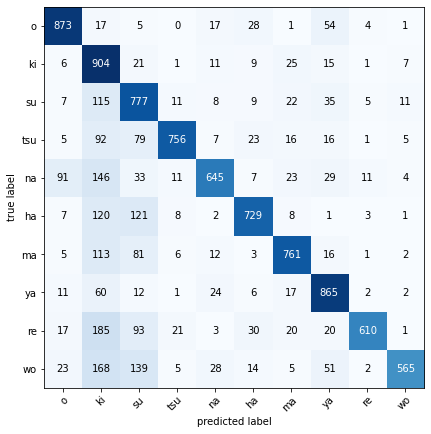

In [21]:
# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names = class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

The convolution architecture seems to be better than baseline model in the Routine notebook. However, notice that the accuracy for the training set is much higher than the accuracy for the testing set, indicating overfitting.The confusion matrix also shows that the model seems to mistake other charaters for `'ki'` the most.